https://pydeseq2.readthedocs.io/

https://ipython.readthedocs.io/en/stable/interactive/magics.html

https://www.youtube.com/watch?v=wIvxFEMQVwg

In [1]:
import anndata as ad
import scanpy as sc

In [2]:
from pydeseq2.preprocessing import deseq2_norm

In [3]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

In [4]:
import numpy as np

In [5]:
import pandas as pd

In [6]:
from matplotlib.pyplot import rc_context

In [7]:
meta = pd.read_csv('samplesheet.csv',index_col=0)
meta.index.name=None

In [8]:
cnt  = pd.read_csv('cnt_matrix.txt', sep='\t')

In [9]:
adata0 = ad.AnnData(
    X   = cnt.drop(columns='name').T.loc[meta.index,:],
    obs = meta[['cell_line','treatment','replicate']],
    var = cnt[['name']]
)

adata1 = adata0[adata0.obs.cell_line.str.contains('A549')].copy()
adata1.obs.replicate = adata1.obs.replicate.astype(int).astype(str)

replicate 2 seems to be weird!

In [10]:
adata2 = adata1[~adata1.obs.replicate.eq('2')].copy()

___

In [11]:
adata = adata2.copy()

In [12]:
adata.layers['raw'] = adata.X

adata.layers['log2_deseq2_norm'] = np.log2(deseq2_norm(adata.X)[0] + 1)

adata.X = adata.layers['log2_deseq2_norm'] 

## PCA

In [13]:
# sc.tl.pca(adata)

In [14]:
# with rc_context({'figure.figsize': (3, 3)}):
#     sc.pl.pca(
#         adata,
#         size=300,
#         color=['treatment','cell_line'],
#     )

#### sgNC

In [66]:
adata_sgNC = adata[adata.obs.cell_line.eq('A549_sgNC1')].copy()

In [67]:
# sc.pp.regress_out(adata_sgNC,'replicate')

In [68]:
sc.tl.pca(adata_sgNC)

/data_gilbert/home/aarab/anaconda3/envs/mamba/envs/pydeseq2/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


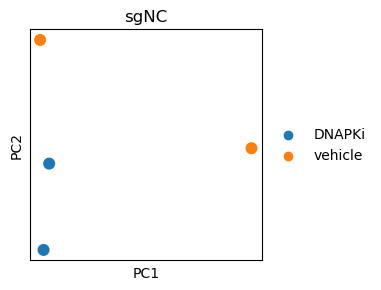

In [74]:
with rc_context({'figure.figsize': (3, 3)}):
    sc.pl.pca(
        adata_sgNC,
        size=300,
        color=['treatment'],
        title='sgNC'
    )

#### sgPRDX1

In [75]:
adata_sgPRDX1 = adata[adata.obs.cell_line.eq('A549_sgPRDX1')].copy()

In [76]:
# sc.pp.regress_out(adata_sgPRDX1,'replicate')

In [77]:
sc.tl.pca(adata_sgPRDX1)

/data_gilbert/home/aarab/anaconda3/envs/mamba/envs/pydeseq2/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


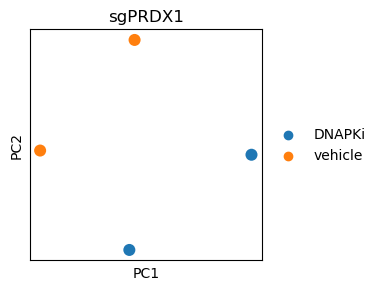

In [78]:
with rc_context({'figure.figsize': (3, 3)}):
    sc.pl.pca(
        adata_sgPRDX1,
        size=300,
        color=['treatment'],
        title='sgPRDX1'
    )

## Comparisons

In [15]:
stat_res = {}

In [45]:
def run_deseq(adata,cond_col,cond_A,cond_B):
    counts = adata.to_df(layer='raw')
    meta = adata.obs

    dds = DeseqDataSet(
        counts=counts,
        metadata=meta,
        design_factors=cond_col,  # compare samples based on the "condition"
        # column ("B" vs "A")
        refit_cooks=True,
        n_cpus=8,
    )

    dds.var = adata.var

    dds.deseq2()

    res = DeseqStats(dds, contrast=[cond_col,cond_B, cond_A], n_cpus=8)
    res.summary()
    
    out = pd.concat([dds.var, res.results_df],axis=1)
    
    return out

### sgNC – treat vs untreat

In [46]:
adata_sgNC = adata[adata.obs.cell_line.eq('A549_sgNC1')].copy()

In [47]:
%%capture --no-stdout

comp_id = 'sgNC'
# treat vs untreat
cond_A = 'vehicle'
cond_B = 'DNAPKi'

stat_res[f'{comp_id}_{cond_B}_vs_{cond_A}'] = run_deseq(
    adata = adata_sgNC,
    cond_col = 'treatment',
    cond_A = cond_A,
    cond_B = cond_B
)

Log2 fold change & Wald test p-value: treatment DNAPKi vs vehicle


### sgPRDX1 – treat vs untreat

In [52]:
adata_sgPRDX1 = adata[adata.obs.cell_line.eq('A549_sgPRDX1')].copy()

In [ ]:
adata_sgPRDX1.obs

In [53]:
%%capture --no-stdout

comp_id = 'sgPRDX1'
# treat vs untreat
cond_A = 'vehicle'
cond_B = 'DNAPKi'

stat_res[f'{comp_id}_{cond_B}_vs_{cond_A}'] = run_deseq(
    adata = adata_sgPRDX1,
    cond_col = 'treatment',
    cond_A = cond_A,
    cond_B = cond_B
)

Log2 fold change & Wald test p-value: treatment DNAPKi vs vehicle


/data_gilbert/home/aarab/anaconda3/envs/mamba/envs/pydeseq2/lib/python3.8/site-packages/pydeseq2/utils.py:674: RuntimeWarning: invalid value encountered in log
  log_alpha_hat = np.log(alpha_hat)
/data_gilbert/home/aarab/anaconda3/envs/mamba/envs/pydeseq2/lib/python3.8/site-packages/pydeseq2/utils.py:715: RuntimeWarning: invalid value encountered in log
  x0=np.log(alpha_hat),
/data_gilbert/home/aarab/anaconda3/envs/mamba/envs/pydeseq2/lib/python3.8/site-packages/numpy/linalg/linalg.py:2079: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
/data_gilbert/home/aarab/anaconda3/envs/mamba/envs/pydeseq2/lib/python3.8/site-packages/pydeseq2/utils.py:674: RuntimeWarning: invalid value encountered in log
  log_alpha_hat = np.log(alpha_hat)
/data_gilbert/home/aarab/anaconda3/envs/mamba/envs/pydeseq2/lib/python3.8/site-packages/pydeseq2/utils.py:715: RuntimeWarning: invalid value encountered in log
  x0=np.log(alpha_hat),
/data_g

## Top hits

In [60]:
from utils import find_top

In [66]:
top_res = {}

for name in stat_res:
    if '_vs_' in name:
        print(name)
        
        top = pd.concat(
            find_top(
                stat_res[name],
                'log2FoldChange', 2,
                'pvalue', 0.05,
            ) 
        )
        
        top_res[name] = top

sgNC_DNAPKi_vs_vehicle
up:  8
down: 4
sgPRDX1_DNAPKi_vs_vehicle
up:  11
down: 9


In [68]:
top_res['sgNC_DNAPKi_vs_vehicle']

,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ENSG00000161204.11,ABCF3,4.313478,2.773597,1.399958,1.981200,0.047569,0.994716
ENSG00000127415.13,IDUA,3.831744,3.672556,1.773822,2.070420,0.038413,0.994716
ENSG00000205765.9,C5orf51,6.883631,2.014179,1.005538,2.003086,0.045168,0.994716
ENSG00000124571.18,XPO5,5.593854,3.235329,1.343853,2.407502,0.016062,0.994716
ENSG00000214765.8,SEPTIN7P2,2.466817,3.007910,1.512086,1.989245,0.046674,0.994716
ENSG00000185418.16,TARS3,3.576030,3.602902,1.799806,2.001827,0.045303,0.994716
ENSG00000122386.11,ZNF205,3.094296,4.933936,2.406194,2.050515,0.040314,0.994716
ENSG00000125354.24,SEPTIN6,5.711146,2.547578,1.184786,2.150243,0.031536,0.994716
ENSG00000276390.1,RP1-197B17.5,2.092021,-3.119212,1.542297,-2.022446,0.043130,0.994716
ENSG00000197299.13,BLM,4.598636,-4.307200,1.729555,-2.490352,0.012762,0.994716


In [69]:
top_res['sgPRDX1_DNAPKi_vs_vehicle']

,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ENSG00000028116.18,VRK2,3.992107,2.182227,0.924064,2.361555,0.018198,0.992869
ENSG00000058866.15,DGKG,2.509403,3.236665,1.520727,2.128366,0.033307,0.992869
ENSG00000145348.17,TBCK,2.509403,3.236665,1.520727,2.128366,0.033307,0.992869
ENSG00000170458.14,CD14,3.981446,2.179024,0.998472,2.182358,0.029083,0.992869
ENSG00000164758.7,MED30,2.741059,2.236675,1.127806,1.983209,0.047344,0.992869
ENSG00000179832.18,MROH1,2.509403,3.236665,1.520727,2.128366,0.033307,0.992869
ENSG00000095539.15,SEMA4G,3.259413,2.526180,1.109007,2.277875,0.022734,0.992869
ENSG00000019505.8,SYT13,4.252393,2.289142,0.917855,2.494013,0.012631,0.992869
ENSG00000087299.12,L2HGDH,4.265925,2.974481,1.418331,2.097169,0.035979,0.992869
ENSG00000174938.15,SEZ6L2,5.491644,2.719401,1.227027,2.216252,0.026674,0.992869


In [ ]:
stat_res['sgPRDX1_DNAPKi_vs_vehicle']

## Heatmaps

In [166]:
import seaborn as sns

In [254]:
import matplotlib.pyplot as plt

In [387]:
def plot_heatmap(adata,samples,genes,fig_size):
    df = adata[adata.obs.Condition.isin(samples),genes].to_df().T
    df.index = adata.var.gene_name[genes]
    
    cm = sns.clustermap(df, z_score=0, cmap = 'RdYlBu_r',
                        vmin=-2,vmax=2,
                       cbar_kws=dict(ticks=[-2,-1, 0, 1,2], orientation='horizontal'), figsize=fig_size
                       )
    
    x0, _y0, _w, _h = cm.cbar_pos
    cm.ax_cbar.set_position(
        # pos[left, bottom, width, height]
        [
            0,# x0, 
            0.82, 
            cm.ax_row_dendrogram.get_position().width*4, 
            0.005]
    )
    cm.ax_cbar.set_title('colorbar title')
    cm.ax_cbar.tick_params(axis='x', length=1)
    # for spine in cm.ax_cbar.spines:
    #     cm.ax_cbar.spines[spine].set_color('crimson')
    #     cm.ax_cbar.spines[spine].set_linewidth(2)
    cm.ax_col_dendrogram.set_visible(False)
    
    return cm

In [382]:
top_res.keys()

dict_keys(['LC_vs_TC', 'LL_vs_TL', 'LC_vs_LL', 'TC_vs_TL', 'LC_vs_PC', 'LL_vs_PL'])

In [402]:
from matplotlib.backends.backend_pdf import PdfPages

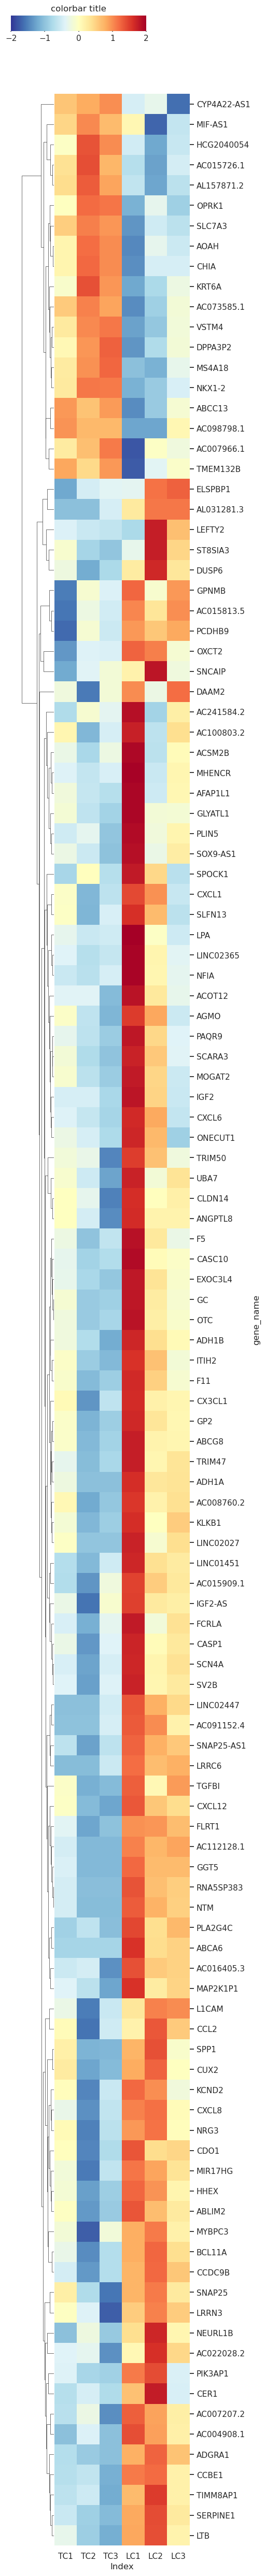

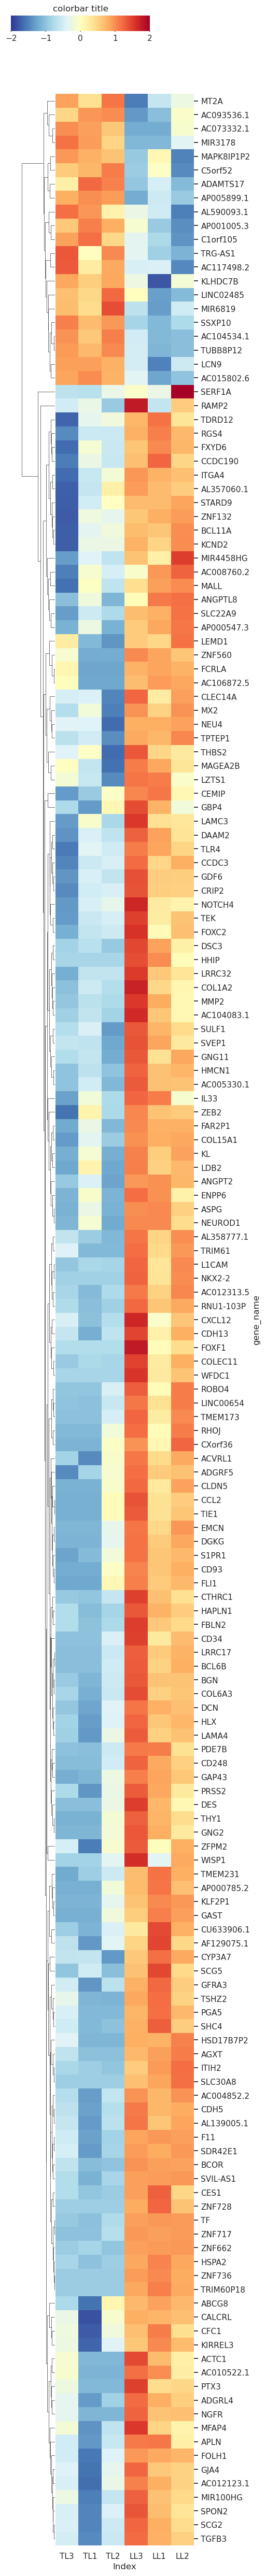

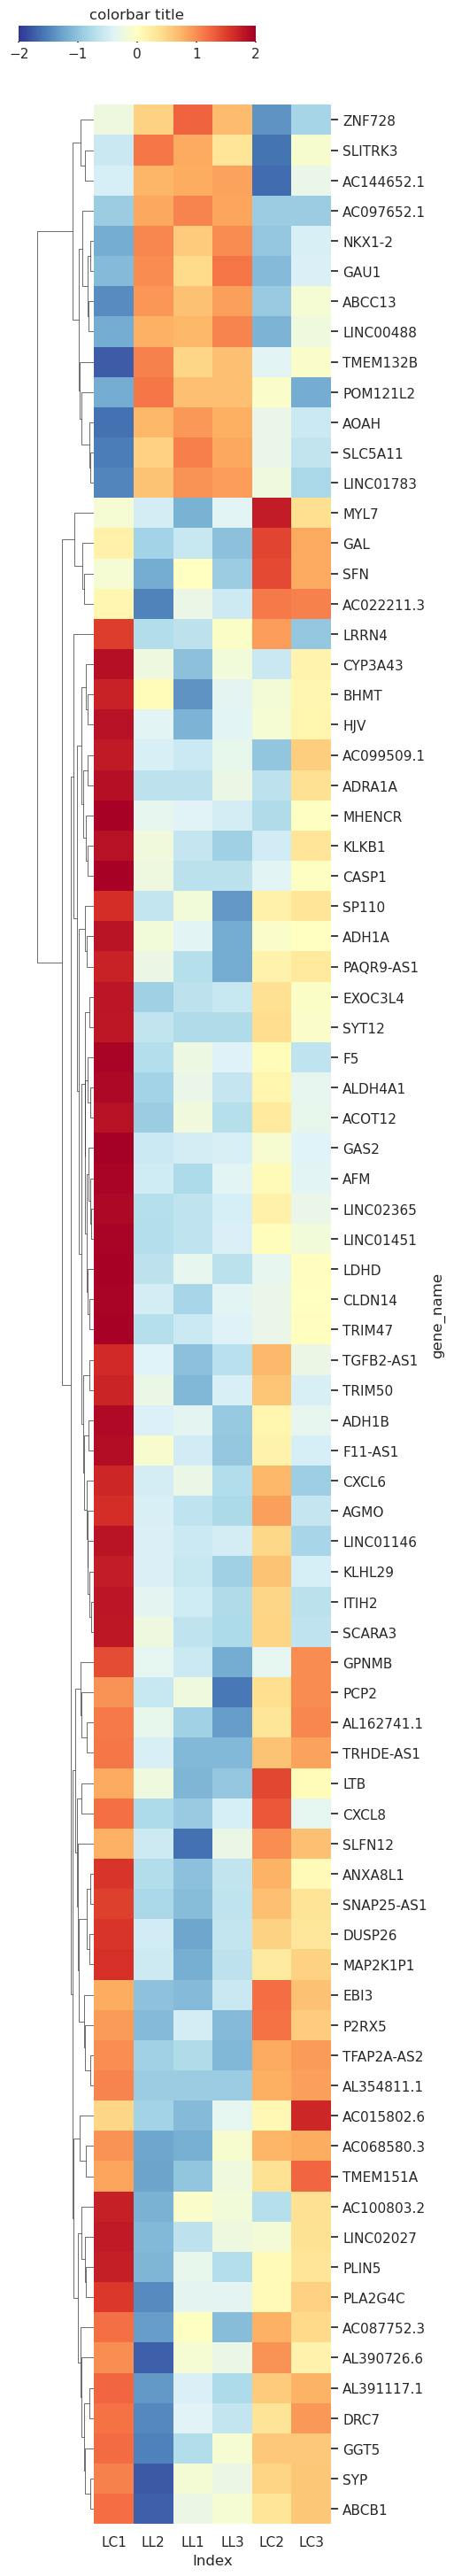

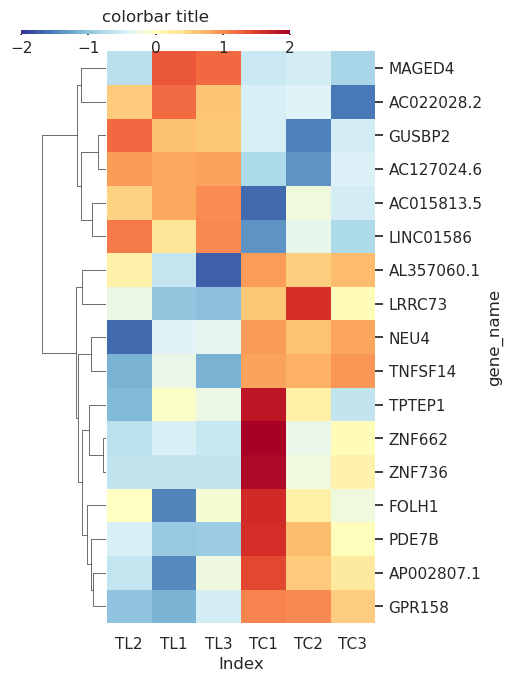

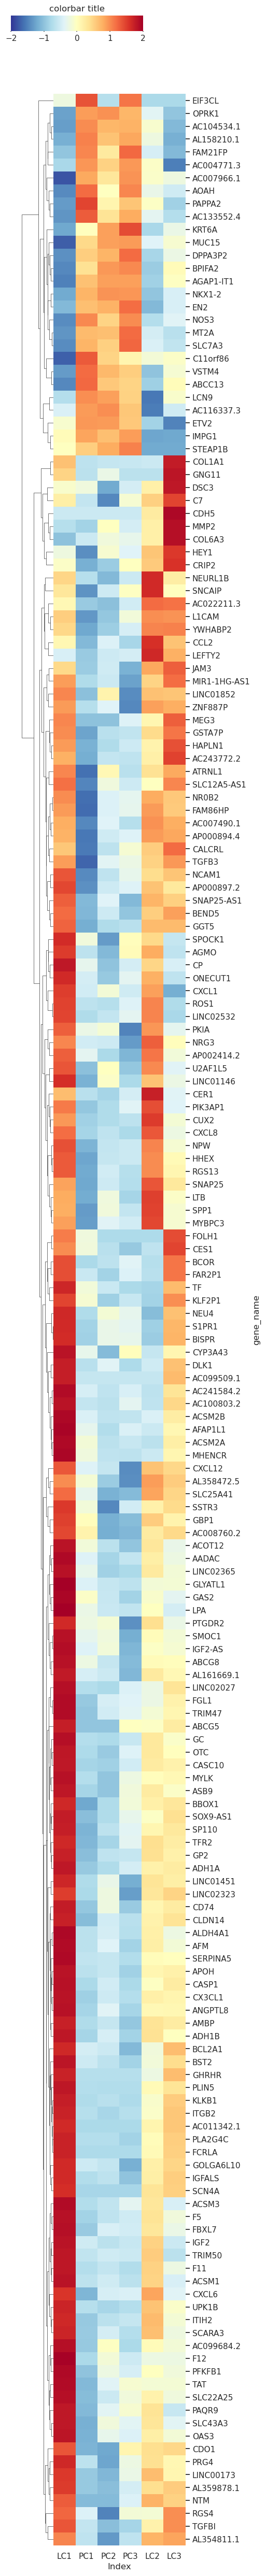

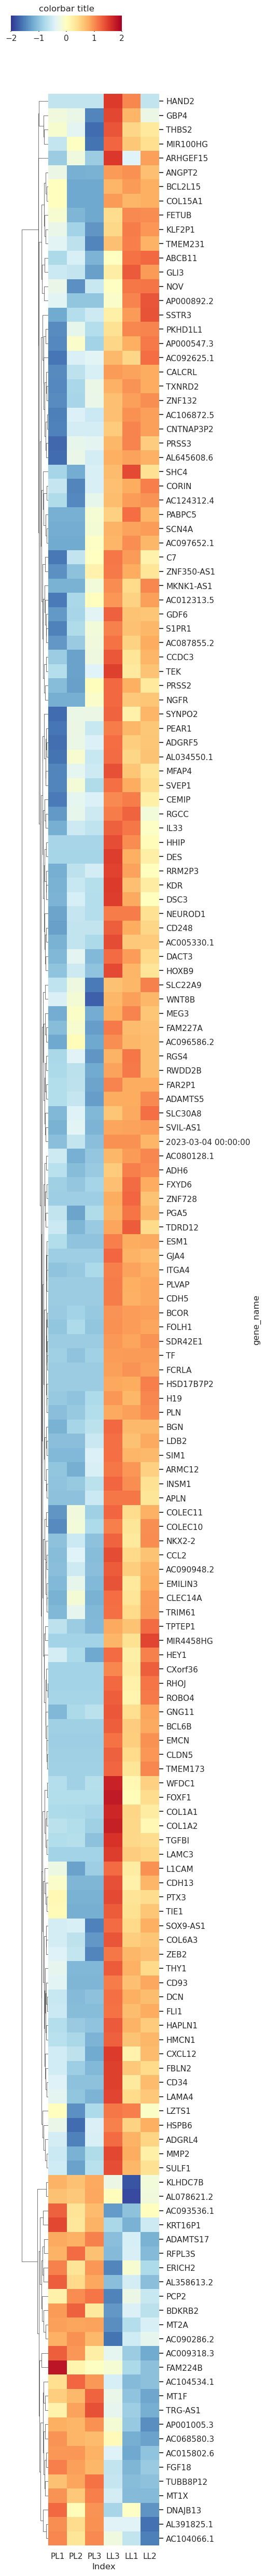

In [409]:
pdf_pages = PdfPages('heatmaps.pdf')

g = plot_heatmap(adata,['LC','TC'],top_res['LC_vs_TC'].index,(5,60))
pdf_pages.savefig(g.fig)

g = plot_heatmap(adata,['LL','TL'],top_res['LL_vs_TL'].index,(5,60))
pdf_pages.savefig(g.fig)

g = plot_heatmap(adata,['LC','LL'],top_res['LC_vs_LL'].index,(5,35))
pdf_pages.savefig(g.fig)

g = plot_heatmap(adata,['TC','TL'],top_res['TC_vs_TL'].index,(5,8))
pdf_pages.savefig(g.fig)

g = plot_heatmap(adata,['LC','PC'],top_res['LC_vs_PC'].index,(5,60))
pdf_pages.savefig(g.fig)

g = plot_heatmap(adata,['LL','PL'],top_res['LL_vs_PL'].index,(5,60))
pdf_pages.savefig(g.fig)

# Write the PDF document to the disk
pdf_pages.close()

## save

In [31]:
stat_res['annotation'] = ann

In [33]:
pd.concat(stat_res,axis=1).to_excel('deseq_results.xlsx')

In [68]:
writer = pd.ExcelWriter('deseq_results_top_hits.xlsx', engine='openpyxl')

for name in top_res:
    top_res[name].to_excel(writer, sheet_name=name)

writer.save()

## 

In [34]:
!date

Sat Jun 17 17:57:06 PDT 2023
